# 0: Section Overview

In this section, we will outline how the data necessary to run the regression models is accessed. we will be using the large dataset from "Our World In Data" and augmenting it with various indexes provided by The Oxford Coronavirus Government Response Tracker (OxCGRT) project. 

# 1: Necessary Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# 2: Data location

Main Dataset: https://github.com/owid/covid-19-data/tree/master/public/data

This link will take you to a GitHub repository. Within the README.md file within this repository, there is an option to download the complete COVID-19 dataset. Please download the CSV version from the various file type options. 


Index Dataset: https://github.com/OxCGRT/covid-policy-tracker/blob/masterdocumentation/index_methodology.md

This link will take you to another GitHub repository, the Oxford Coronavirus Government Response tracker project. In Particular, it will take you to the methodology for calculating indices. Under the Indices header, there is an option to download the OxCGRT_latest.csv file containing the necessary indices we shall use for this project. 

### Indices Outine

Here, we will provide a brief description of the indices that

[INSERT]


# 3: Dataset Augmentation

In order to continue, we need to combine the 2 datasets. In this section we will take the necessary steps to augment the datasets. Note, the augmented test and training datasets are already stored within the GitHub Repository under Train_and_Test_data however we will still show the steps needed to get to these final augmented datasets.

In [50]:
# Load Dataset 1 (e.g., COVID-19 data from Our World in Data)

owid_filepath = r'C:\Users\markm\OneDrive\Documents\University\Year 4\dst\data\our_world_in_data_covid_data.csv' # Enter your file path for the our world in data dataset
ox_index_filepath = r'C:\Users\markm\OneDrive\Documents\University\Year 4\dst\data\OxCGRT_timeseries_all.csv' # Enter your file path for the Oxford Coronavirus government response tracker project dataset

df_covid = pd.read_csv(owid_filepath)

# Load Dataset 2 (e.g., Policy Tracker from OxCGRT)
df_policy = pd.read_csv(ox_index_filepath)


In the oxford index dataset, there are many columns that we don't require. For that reason, let us extract only the columns that we want to keep (these being those containing the various indices that we care about). Additionally, we only want to consider these indices on a national level. Certain countries (for example, Australia) have multiple rows as their state-level data is provided seperately. For that reason, we will filter out those rows and only include rows that contain data on a national jurisdiction level. 

In [51]:
ox_index_filepath = r'C:\Users\markm\OneDrive\Documents\University\Year 4\dst\data\OxCGRT_timeseries_all.xlsx'

df_stringency = pd.read_excel(ox_index_filepath, sheet_name='stringency_index_avg')
df_containment_health = pd.read_excel(ox_index_filepath, sheet_name='containment_health_index_avg')
df_government_response = pd.read_excel(ox_index_filepath, sheet_name='government_response_index_avg')
df_economic_support = pd.read_excel(ox_index_filepath, sheet_name='economic_support_index')

# List of the dataframes to process
indexes = [df_stringency, df_containment_health, df_government_response, df_economic_support]
filtered_indexes = []

# Filter each dataframe and store the filtered version in 'filtered_indexes'
for df in indexes:
    filtered_df = df[df['jurisdiction'] == 'NAT_TOTAL']
    filtered_indexes.append(filtered_df)

# Assign the filtered dataframes back to their original variables (optional)
df_stringency, df_containment_health, df_government_response, df_economic_support = filtered_indexes

# Save the filtered dataframes as separate CSV files
df_stringency.to_csv('stringency_index',index=False)
df_containment_health.to_csv('containment_health_filtered.csv', index=False)
df_government_response.to_csv('government_response_filtered.csv', index=False)
df_economic_support.to_csv('economic_support_filtered.csv', index=False)


In [52]:
print(df_containment_health.head())

  country_code country_name region_code region_name jurisdiction  01Jan2020  \
0          ABW        Aruba         NaN         NaN    NAT_TOTAL        0.0   
1          AFG  Afghanistan         NaN         NaN    NAT_TOTAL        0.0   
2          AGO       Angola         NaN         NaN    NAT_TOTAL        0.0   
3          ALB      Albania         NaN         NaN    NAT_TOTAL        0.0   
4          AND      Andorra         NaN         NaN    NAT_TOTAL        0.0   

   02Jan2020  03Jan2020  04Jan2020  05Jan2020  ...  11Feb2023  12Feb2023  \
0        0.0        0.0        0.0        0.0  ...        NaN        NaN   
1        0.0        0.0        0.0        0.0  ...        NaN        NaN   
2        0.0        0.0        0.0        0.0  ...        NaN        NaN   
3        0.0        0.0        0.0        0.0  ...        NaN        NaN   
4        0.0        0.0        0.0        0.0  ...        NaN        NaN   

   13Feb2023  14Feb2023  15Feb2023  16Feb2023  17Feb2023  18Feb2023 

Now, we have separated each index into its own dataframe. Our main problem is that unlike the OWID dataset where date is one column and there are multiple rows per country, the Oxford dataset has each date as is its own column and a singular row for a country. We need to reformat this so that it matches the format of the OWID dataset so that it can then be used in the model. To do this, we define the following function:

In [53]:
def transposer(dataset,index_name):
    # Create a complete date range from January 5, 2020, to August 4, 2024 - this datarange matches that of each country in the OWID dataset
    date_range = pd.date_range(start='05-Jan-2020', end='04-Aug-2024', freq='D')
    complete_dates_df = pd.DataFrame(date_range, columns=['date'])  # Create a DataFrame with all dates

# Create a list to store the complete DataFrames for each country
    complete_dataframes = []

# Iterate through each row in df_containment_health
    for row_index in range(dataset.shape[0]):  # Iterate through rows
        # Select the row you want to transpose (excluding first 9 columns) - we want to start on 05-Jan-2020
        row_to_transpose = dataset.iloc[row_index][9:]  # Adjust index as needed
        transposed_row = row_to_transpose.transpose()  # Transpose the row

         # Convert the transposed row to a DataFrame
        transposed_df = pd.DataFrame(transposed_row).reset_index()
        transposed_df.columns = ['date', index_name+' ' 'Index']  # Rename columns for clarity

         # Ensure the 'Date' column is in datetime format
        transposed_df['date'] = pd.to_datetime(transposed_df['date'], format='%d%b%Y')

        # Merge with the complete date range DataFrame
        complete_df = complete_dates_df.merge(transposed_df, on='date', how='left')

        # Add a new column for country code or name if needed
        complete_df['iso_code'] = dataset.iloc[row_index, 0]  # Assuming the first column is the country code/name

        # Append the complete DataFrame for this country to the list
        complete_dataframes.append(complete_df)

# Concatenate all the DataFrames in the list into a single DataFrame
    final_df = pd.concat(complete_dataframes, ignore_index=True)
    return final_df

Let us look at what this function does to one of our dataframes.

In [54]:
transposed_containment_health = transposer(df_containment_health, 'CH')

print('Before Transposing')
print(df_containment_health.head())
print()
print('After Transposing')
print(transposed_containment_health.head())
print()

Before Transposing
  country_code country_name region_code region_name jurisdiction  01Jan2020  \
0          ABW        Aruba         NaN         NaN    NAT_TOTAL        0.0   
1          AFG  Afghanistan         NaN         NaN    NAT_TOTAL        0.0   
2          AGO       Angola         NaN         NaN    NAT_TOTAL        0.0   
3          ALB      Albania         NaN         NaN    NAT_TOTAL        0.0   
4          AND      Andorra         NaN         NaN    NAT_TOTAL        0.0   

   02Jan2020  03Jan2020  04Jan2020  05Jan2020  ...  11Feb2023  12Feb2023  \
0        0.0        0.0        0.0        0.0  ...        NaN        NaN   
1        0.0        0.0        0.0        0.0  ...        NaN        NaN   
2        0.0        0.0        0.0        0.0  ...        NaN        NaN   
3        0.0        0.0        0.0        0.0  ...        NaN        NaN   
4        0.0        0.0        0.0        0.0  ...        NaN        NaN   

   13Feb2023  14Feb2023  15Feb2023  16Feb2023  17

Great! So now our data looks more similar to the data within the OWID dataset. Let's run this function on the remaining index datasets.

In [55]:
transposed_stringency = transposer(df_stringency,'Stringency')
transposed_government_response = transposer(df_government_response, 'Gov Resp')
transposed_economic_support = transposer(df_economic_support, 'Econ Sup')

Let us now combine all of these into a singular dataframe - namely, df_combined. Note that the iso_code and date columns will be used together as a composite primary key to differentiate between rows. 

In [56]:
df_combined = transposed_stringency.join(transposed_containment_health, how='inner', lsuffix='', rsuffix='_containment')
df_combined = df_combined.join(transposed_government_response, how='inner', lsuffix='_df_combined', rsuffix='_govresp')
df_combined = df_combined.join(transposed_economic_support, how='inner', lsuffix='_df_combined', rsuffix='_econsup')
# # Select only the desired columns
df_combined = df_combined[['date', 'iso_code', 'Stringency Index', 'CH Index', 'Gov Resp Index', 'Econ Sup Index']]
# Display the result - test output
print(df_combined[df_combined['Stringency Index'] != 0])

             date iso_code Stringency Index CH Index Gov Resp Index  \
71     2020-03-16      ABW            11.11     9.52           8.33   
72     2020-03-17      ABW            22.22    16.67          14.58   
73     2020-03-18      ABW            33.33    26.19          22.92   
74     2020-03-19      ABW            33.33    29.76          26.04   
75     2020-03-20      ABW            33.33    29.76          26.04   
...           ...      ...              ...      ...            ...   
313033 2024-07-31      ZWE              NaN      NaN            NaN   
313034 2024-08-01      ZWE              NaN      NaN            NaN   
313035 2024-08-02      ZWE              NaN      NaN            NaN   
313036 2024-08-03      ZWE              NaN      NaN            NaN   
313037 2024-08-04      ZWE              NaN      NaN            NaN   

       Econ Sup Index  
71                0.0  
72                0.0  
73                0.0  
74                0.0  
75                0.0  
...

Now we need to make sure our OWID dataset is in the appropriate format to combine with the Oxford dataset. First we will reformat the date column.

In [57]:
df_covid['date'] = pd.to_datetime(df_covid['date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [58]:
print(df_covid['date'].head())

0    2020-01-05
1    2020-01-06
2    2020-01-07
3    2020-01-08
4    2020-01-09
Name: date, dtype: object


Besides this, the OWID dataset looks ready to be augmented with the indices we specified from the Oxford dataset.

In [59]:
# Ensure the OWID dataset's date column is in datetime format
df_covid['date'] = pd.to_datetime(df_covid['date'], format='%Y-%m-%d', errors='coerce')

# Ensure your other dataset's date column is also in datetime format (assuming it's named 'date')
df_combined['date'] = pd.to_datetime(df_combined['date'], format='%Y-%m-%d', errors='coerce')

# Now perform the merge (assuming 'date' and 'iso_code' are the keys)
merged_df = pd.merge(df_combined, df_covid, on=['iso_code', 'date'], how='inner')
print()
# Check the merged dataframe
print(merged_df.head())



        date iso_code Stringency Index CH Index Gov Resp Index Econ Sup Index  \
0 2020-01-05      ABW              0.0      0.0            0.0            0.0   
1 2020-01-06      ABW              0.0      0.0            0.0            0.0   
2 2020-01-07      ABW              0.0      0.0            0.0            0.0   
3 2020-01-08      ABW              0.0      0.0            0.0            0.0   
4 2020-01-09      ABW              0.0      0.0            0.0            0.0   

       continent location  total_cases  new_cases  ...  male_smokers  \
0  North America    Aruba          0.0        0.0  ...           NaN   
1  North America    Aruba          0.0        0.0  ...           NaN   
2  North America    Aruba          0.0        0.0  ...           NaN   
3  North America    Aruba          0.0        0.0  ...           NaN   
4  North America    Aruba          0.0        0.0  ...           NaN   

   handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
0    

The datasets have been merged without any immediate error messages however we are not yet finished. 

Now our columns should be in an appropriate order, let us print them all out to check.

In [60]:
print(merged_df.columns)

Index(['date', 'iso_code', 'Stringency Index', 'CH Index', 'Gov Resp Index',
       'Econ Sup Index', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_b

Note, we do have 2 columns, Stringency Index and stringency index. Whilst this is not a large problem, it can be observed that they are not exactly numerically equivalenet. The below code displays row where these columns differ in their value. It is not an easy to decide on which column to use. On the one hand, it may be better to use the initial column since we have used it in previous analysis and it comes from our initial OWID dataset. However, the augmented column has more documentation and specific insight into how it was calculated and can therefore could provide a more reliable figure. For these reasons we will just take a mean average of these 2 columns and use this. 

In [61]:
mask = merged_df['Stringency Index'] != merged_df['stringency_index']

# Step 2: Filter the DataFrame using the mask
differences = merged_df[mask][['date','Stringency Index','stringency_index','iso_code']].dropna()

# test = differences[['stringency_index', 'Stringency Index']].mean(axis=1)
# print(test)

# Display the rows where the values differ
print("Rows where Column_A and Column_B differ:")

print(differences)

Rows where Column_A and Column_B differ:
             date Stringency Index  stringency_index iso_code
2326   2021-10-18            38.89             36.11      AFG
2327   2021-10-19            38.89             36.11      AFG
2328   2021-10-20            38.89             36.11      AFG
2329   2021-10-21            38.89             36.11      AFG
2330   2021-10-22            38.89             36.11      AFG
...           ...              ...               ...      ...
309280 2022-12-27             8.33             13.89      ZMB
309281 2022-12-28             8.33             13.89      ZMB
309282 2022-12-29             8.33             13.89      ZMB
309283 2022-12-30             8.33             13.89      ZMB
309284 2022-12-31             8.33             13.89      ZMB

[20595 rows x 4 columns]


In [62]:
# Step 1: Calculate the mean and add it back to the original DataFrame
merged_df['mean_stringency'] = merged_df[['Stringency Index', 'stringency_index']].mean(axis=1, skipna=True)

# Step 2: Apply the filtering conditions on the original DataFrame
selected_row_mean_check = merged_df.loc[(merged_df['date'] == '2022-12-27') & (merged_df['iso_code'] == 'ZMB'), 'mean_stringency']

# Display the result
print(selected_row_mean_check)


merged_df = merged_df.drop(columns=['Stringency Index'])
merged_df = merged_df.drop(columns=['stringency_index'])



309280    11.11
Name: mean_stringency, dtype: object


The above block takes the average of the two columns for some row. We can check it is working by computing the average by hand for some row and checking it is the same provided above.

Let us move the continent and location columns to the front.

In [63]:
all_columns = list(merged_df.columns)
# Move 'continent' and 'location' next to 'date' and 'iso_code'
new_column_order = ['date', 'iso_code', 'continent', 'location', 'mean_stringency'] + [col for col in all_columns if col not in ['date', 'iso_code', 'continent', 'location','mean_stringency']]
merged_df = merged_df[new_column_order]
merged_df.head()

,date,iso_code,continent,location,mean_stringency,CH Index,Gov Resp Index,Econ Sup Index,total_cases,new_cases,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN


We now need to add an additional column to the dataset. this column will be called days_since. This column will effectively represent the date column in our future regression models however these models do not interpret timestamp objects and we will get an error that looks like this:

TypeError: float() argument must be a string or a real number, not 'Timestamp'

Hence this new column is necessary.

In [64]:
merged_df['days_since'] = merged_df.groupby('iso_code')['date'].transform(lambda x: (x - x.min()).dt.days)

This column will start at 0 (representing the first day of recording, the 5th of January 2020) and end at 1673 (representing the last day of recording, the 4th of August 2023)

In [65]:
print(merged_df.columns)

Index(['date', 'iso_code', 'continent', 'location', 'mean_stringency',
       'CH Index', 'Gov Resp Index', 'Econ Sup Index', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_bo

: 

# 4. Exploratory Data Analysis

In this section, we will explore our newly augmented dataset through exploratory data analysis. This will help use to understand the relationships between the covariate variable features and our target variable, namely, the total vaccinations per hundred.



## Plot 1: Line Graph of normalised total vaccinations over the time period

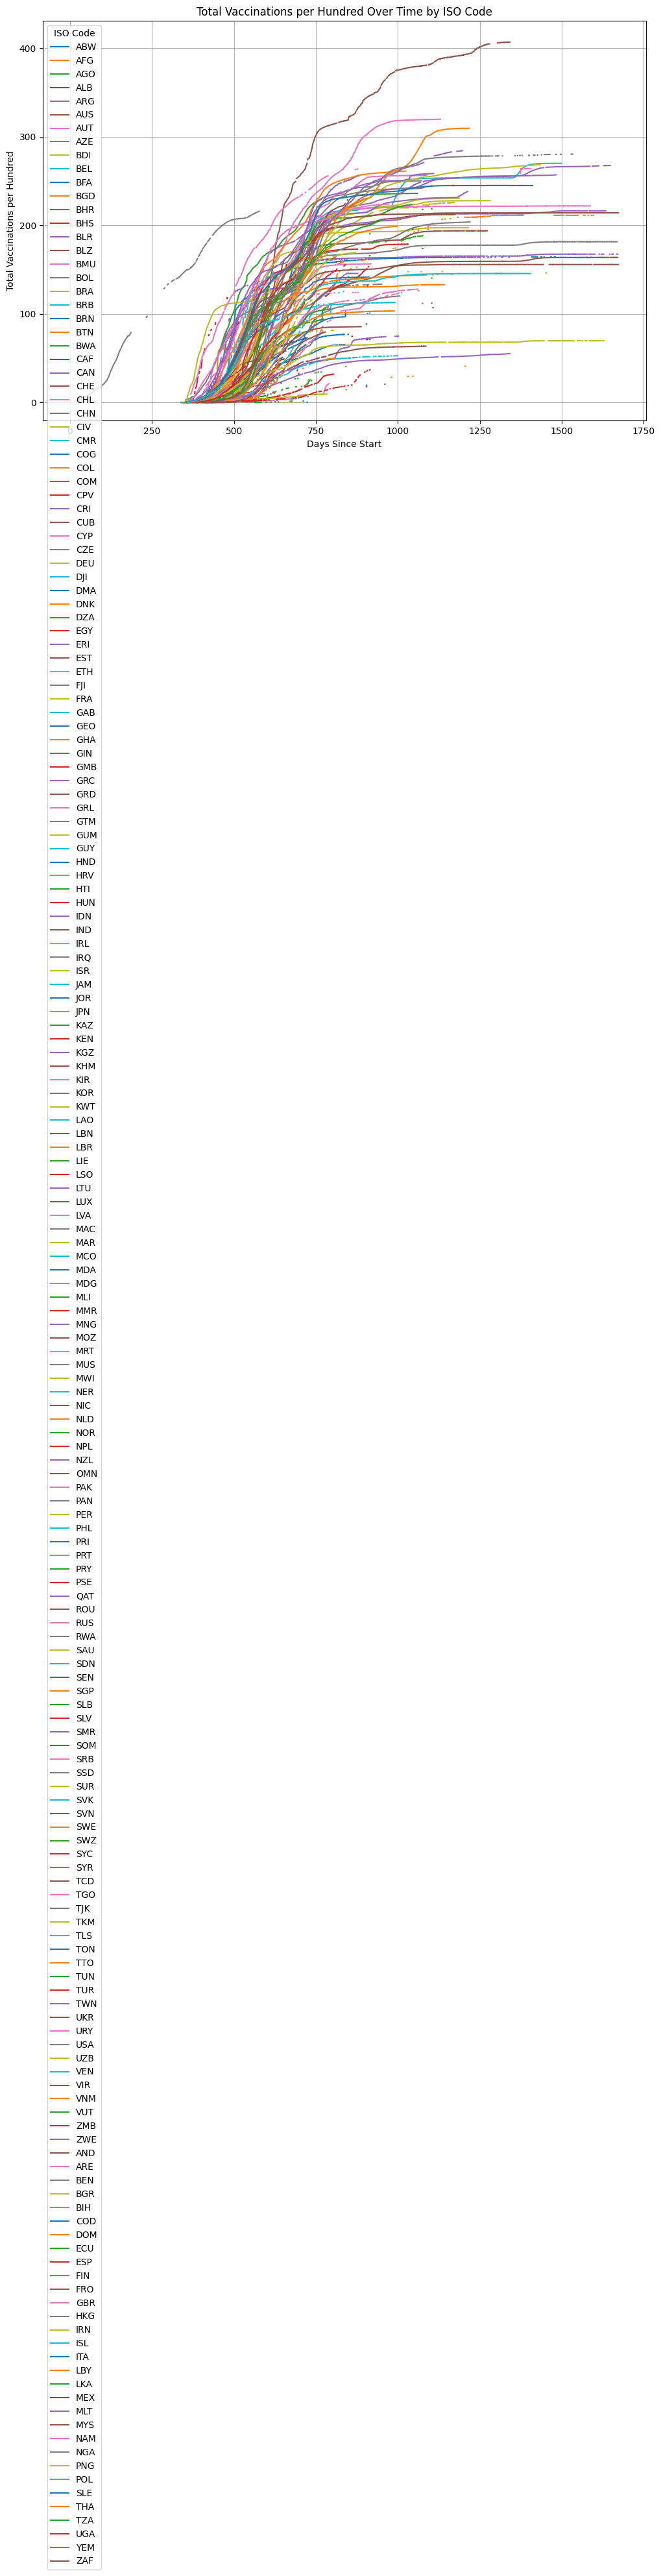

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have 'days_since', 'total_vaccinations_per_hundred', and 'iso_code' in your dataset
plt.figure(figsize=(12, 8))

# Loop through each unique iso_code and plot for each one
for iso in combined_w_string_cols['iso_code'].unique():
    subset = combined_w_string_cols[combined_w_string_cols['iso_code'] == iso]
    plt.plot(subset['days_since'], subset['total_vaccinations_per_hundred'], label=iso)

# Add title and labels
plt.title('Total Vaccinations per Hundred Over Time by ISO Code')
plt.xlabel('Days Since Start')
plt.ylabel('Total Vaccinations per Hundred')

# Show legend and grid
plt.legend(title='ISO Code')
plt.grid(True)

# Show the plot
plt.show()


Since we have included all the countries' data for this plot, the legend is incredibly large. Let's randomely select a subset of countries such that this does not happen.

### Reducing the number of countries displayed on Plot 1

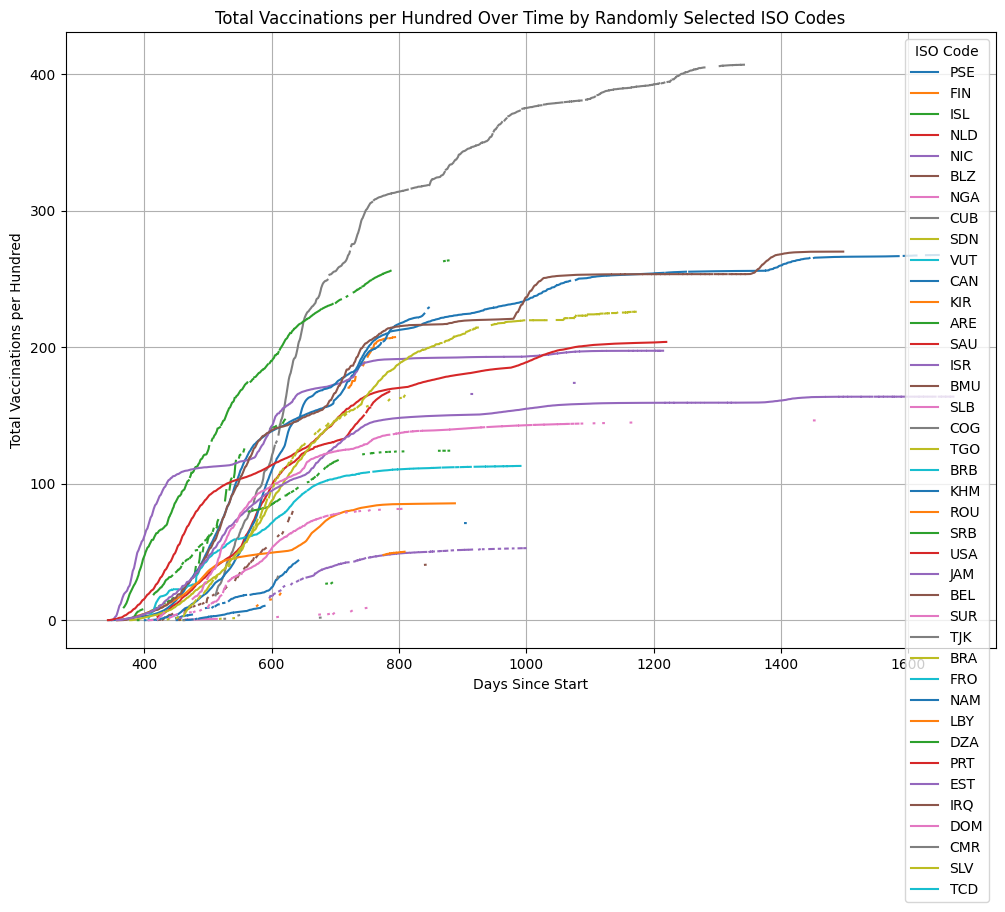

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'combined_w_string_cols' is your DataFrame

# Get unique ISO codes and randomly sample 20 of them
random_iso_codes = combined_w_string_cols['iso_code'].unique()
random_selected_iso_codes = pd.Series(random_iso_codes).sample(n=40, random_state=42).tolist()

plt.figure(figsize=(12, 8))

# Loop through the randomly selected ISO codes and plot for each one
for iso in random_selected_iso_codes:
    subset = combined_w_string_cols[combined_w_string_cols['iso_code'] == iso]
    plt.plot(subset['days_since'], subset['total_vaccinations_per_hundred'], label=iso)

# Add title and labels
plt.title('Total Vaccinations per Hundred Over Time by Randomly Selected ISO Codes')
plt.xlabel('Days Since Start')
plt.ylabel('Total Vaccinations per Hundred')

# Show legend and grid
plt.legend(title='ISO Code')
plt.grid(True)

# Show the plot
plt.show()


Analysis

## Plot 2: Scatter Graph of response variable against Independent Variables

### Data preprocessing

We were getting the following error: ValueError: cannot reindex on an axis with duplicate labels. This is due to the fact that when we've aggregated our train and test dataset back together, we have duplicated index values for each row up to the final row of the test data (the smaller of the two datasets). i.e. both first rows of each dataset are indexed 0, the second rows of each are both indexed 1 (and so on). Hence we just need to perform a simple index reset.

In [ ]:
combined_w_string_cols = combined_w_string_cols.reset_index(drop=True)

For the same reasons as plot 1, we will display only a randomely selected few iso_codes on the plot.

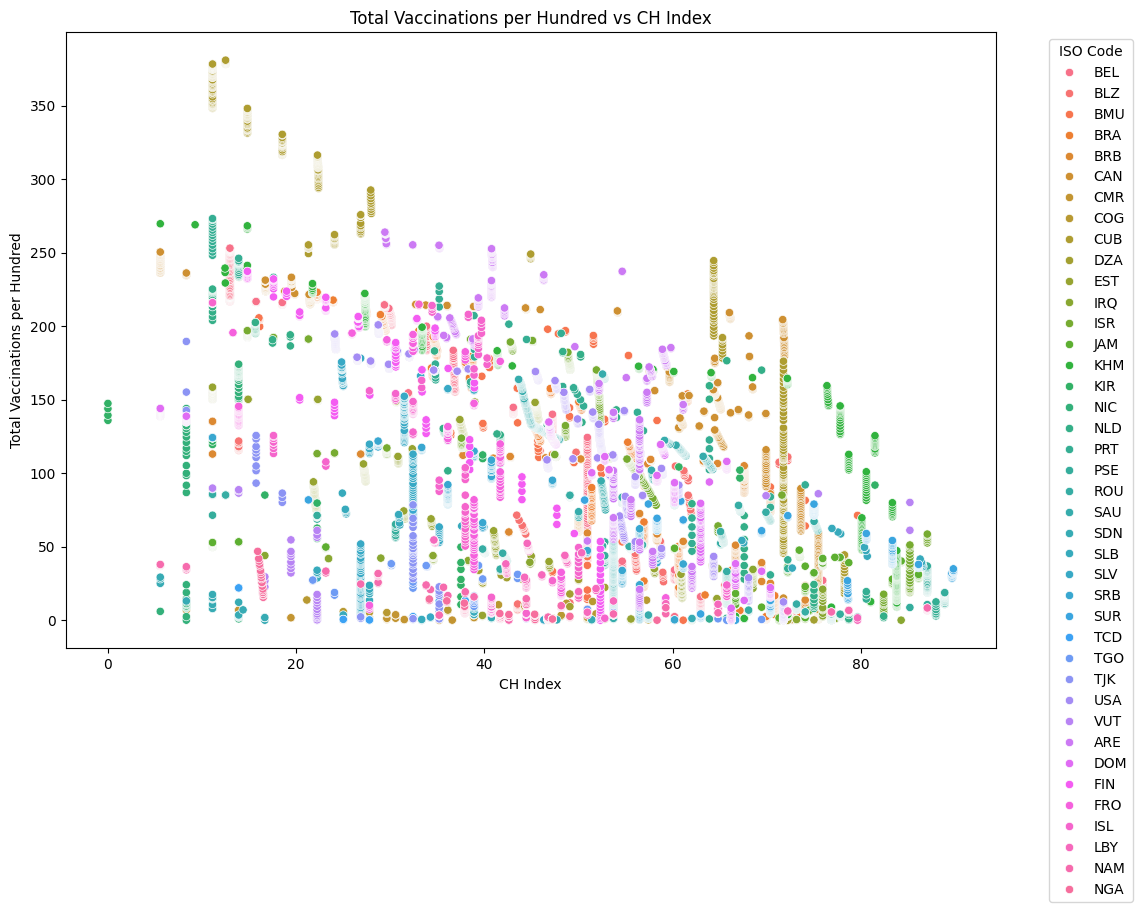

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_w_string_cols[combined_w_string_cols['iso_code'].isin(random_selected_iso_codes)], x='mean_stringency', y='total_vaccinations_per_hundred', hue='iso_code')

# Set plot title and labels
plt.title('Total Vaccinations per Hundred vs CH Index')  # Update title to reflect correct x-axis
plt.xlabel('CH Index')  # Update x-label to reflect actual data
plt.ylabel('Total Vaccinations per Hundred')

# Display legend and show plot
plt.legend(title='ISO Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Analysis

## Plot 3: Pair Plot

This Pair Plot is an extention of the previous plot. We can use the pair plot To visually inspect the relationships between covariates and the reproduction rate, especially useful for identifying non-linear relationships or interactions.

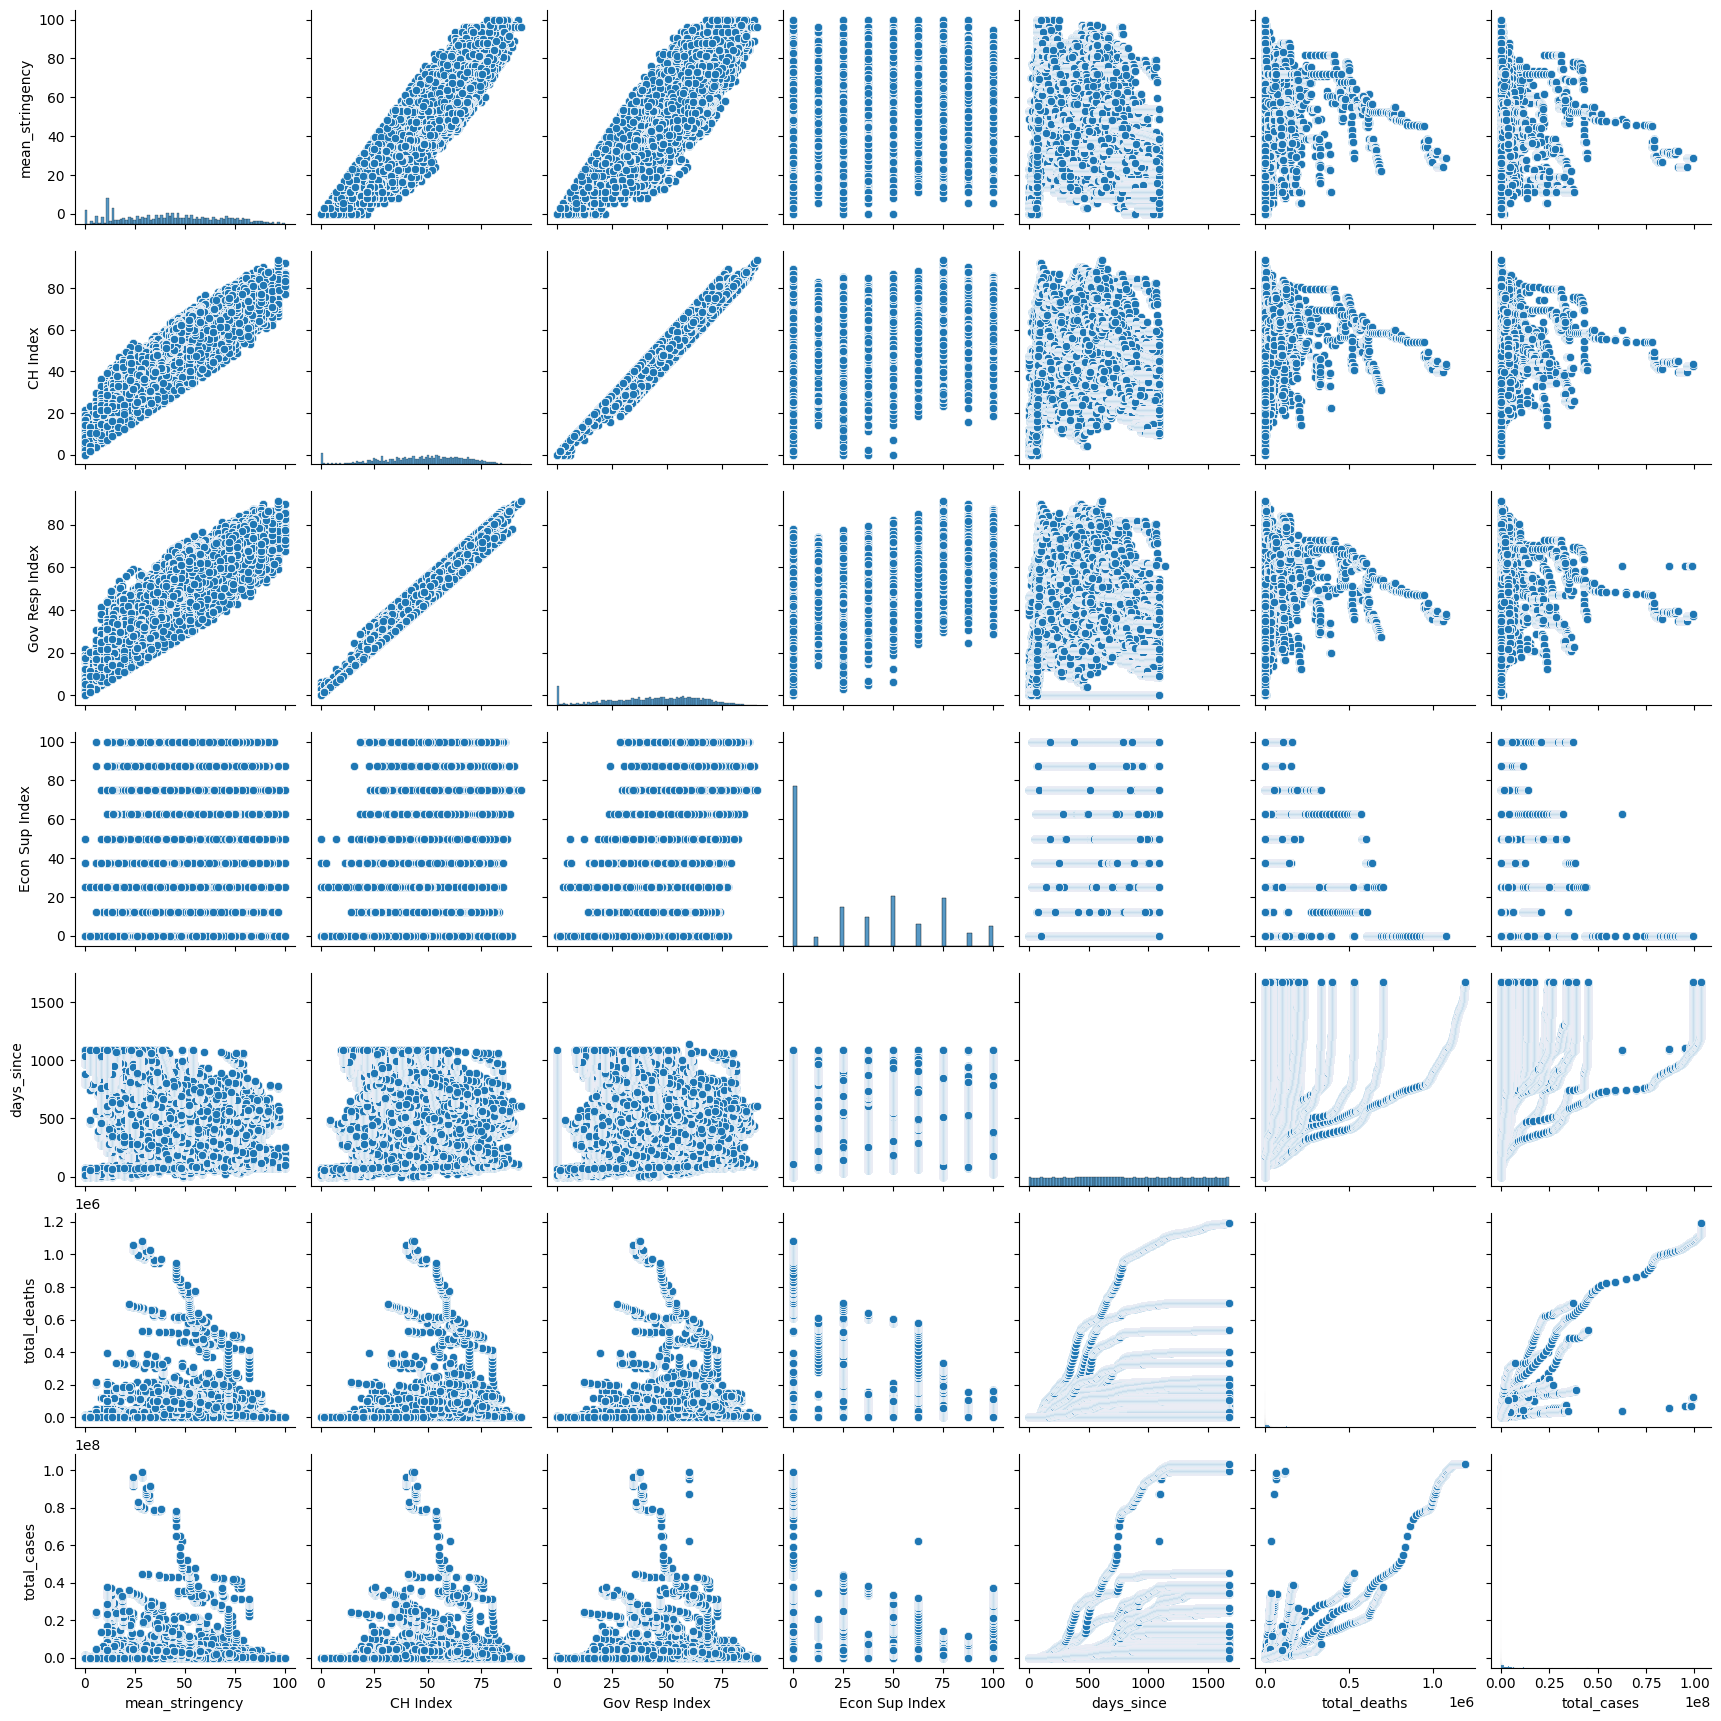

In [ ]:
c = ['mean_stringency','CH Index', 'Gov Resp Index', 'Econ Sup Index','days_since','total_deaths','total_cases']
sns.pairplot(combined_w_string_cols, vars=c)
plt.show()

## Plot 4: Correlation Matrix and Heatmap

To check linear relationships between covariates and the reproduction rate

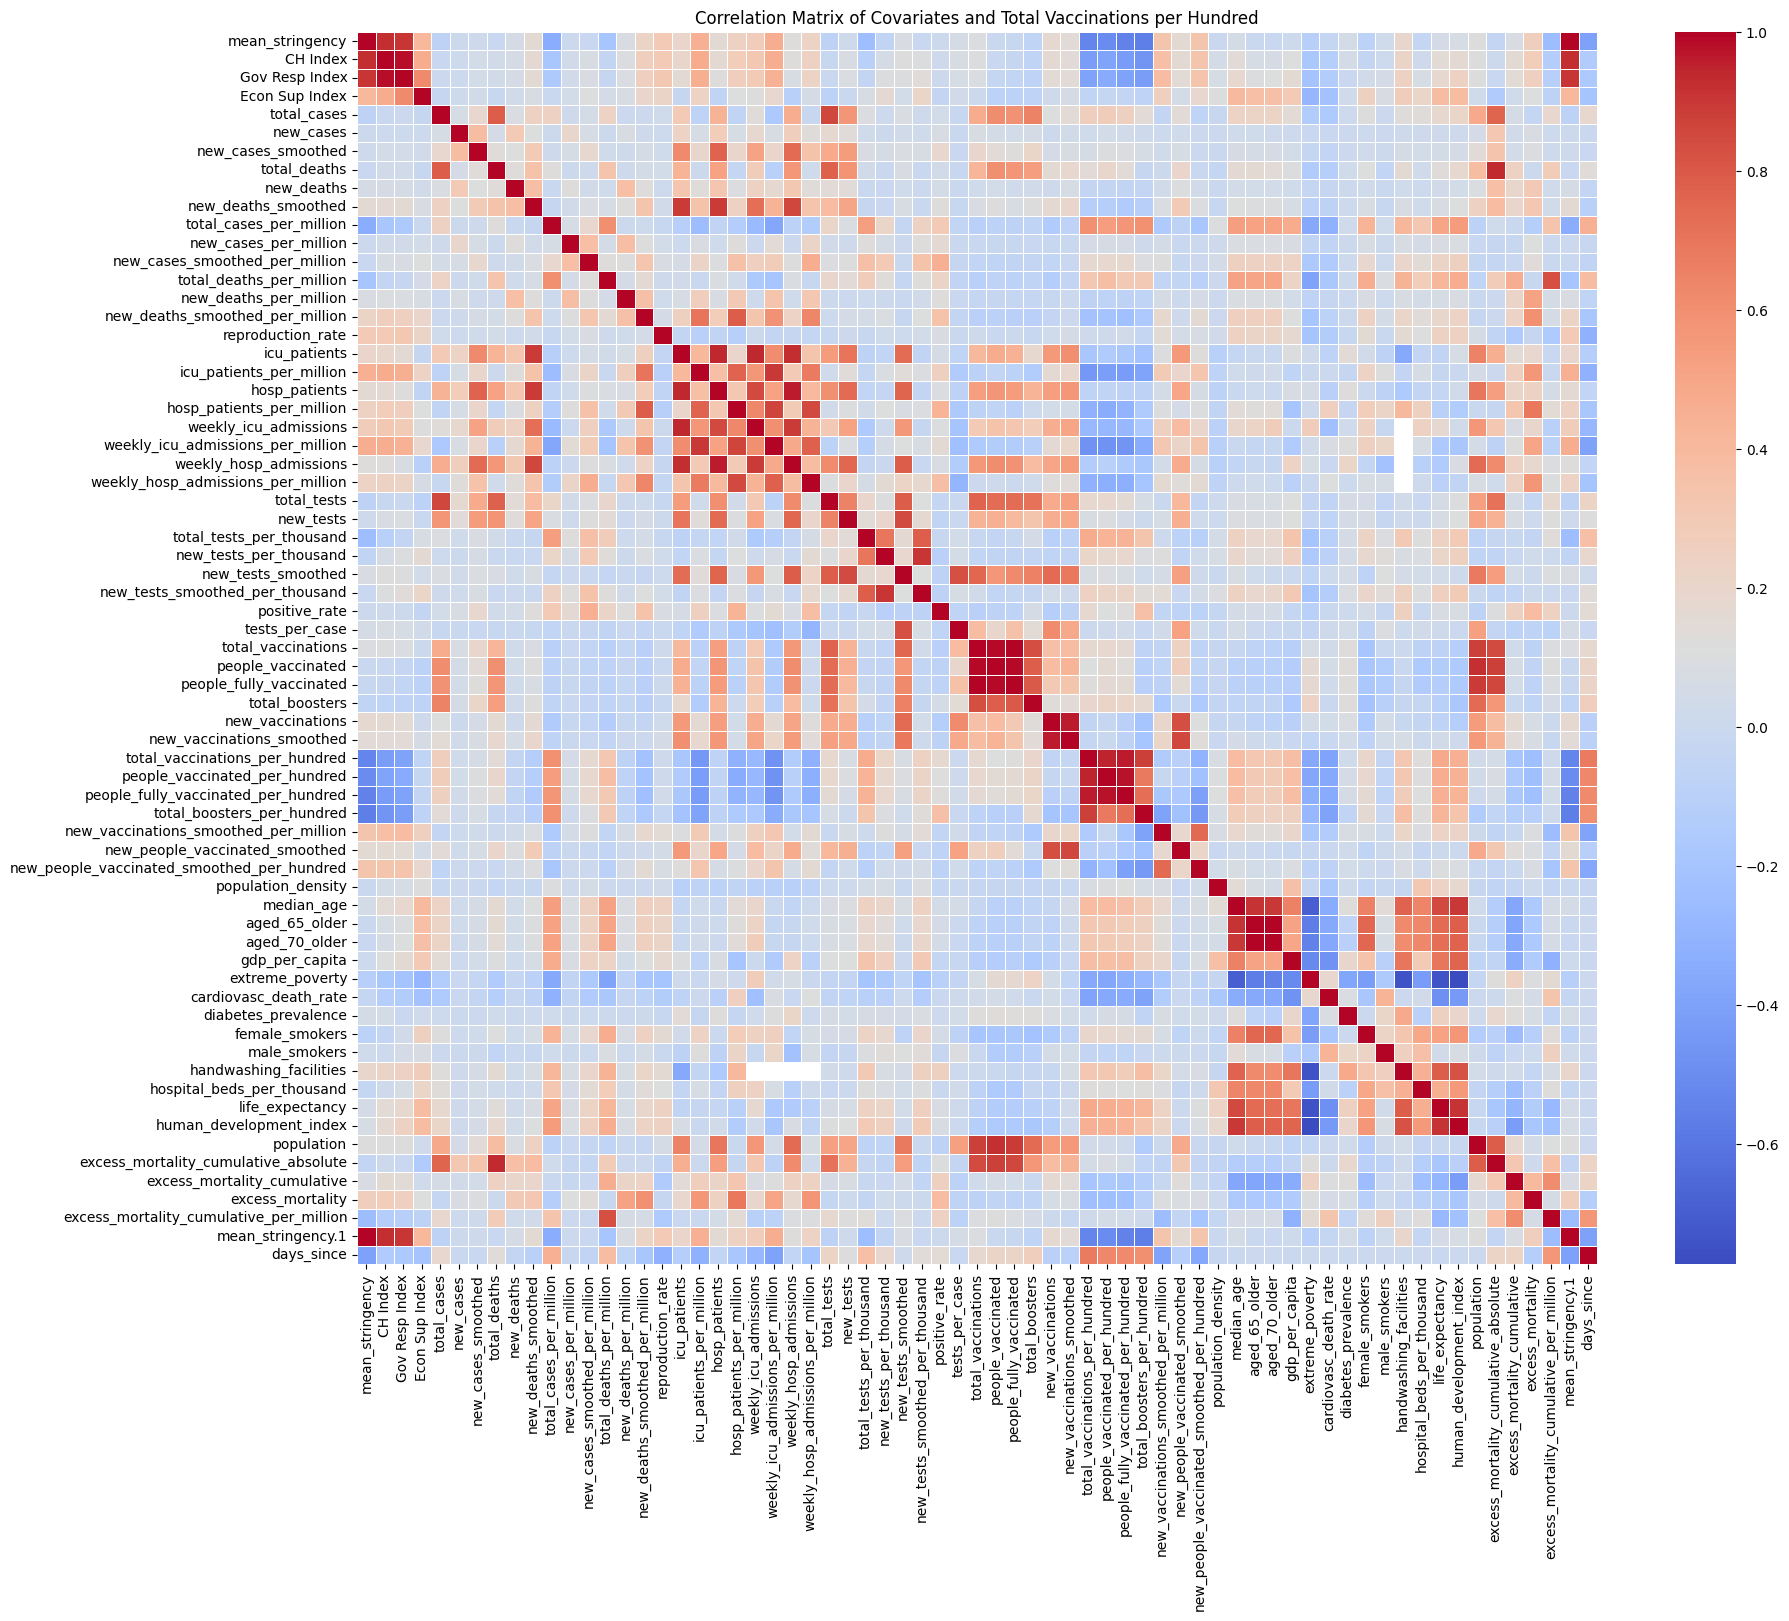

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


combined = pd.concat([train_data_string_cols_rem, test_data_string_cols_rem], axis=0)  # Combine rows (axis=0)
combined = combined.drop(columns=['tests_units'])
#print(combined.columns)

plt.figure(figsize=(20, 16))
sns.heatmap(combined.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Covariates and Total Vaccinations per Hundred")
plt.show()

analysis

# 5. Data Cleaning

To ensure that each model that we impliment uses the same test and training datasets, we will clean the data here. In the following section of this document (6: Splitting our Data into Training and Testing Data), we will upload the test and training files that will then be accessed for the running of each model.

# 6: Splitting our Data into Training and Testing Data

Now we are going to split our data up into test and training data. Due to the nature of this particular project where we are aiming to predict the reproduction rate for a particular country over the entire period of time, it makes intuitive sense to due a train/test split on a country level i.e. we aren't going to design a split such that some of a country's data is in training and some of it is in testing. 

Let us first see how many countries there are in our dataset.

In [18]:
print(merged_df['iso_code'].unique())
print(len(merged_df['iso_code'].unique()))

['ABW' 'AFG' 'AGO' 'ALB' 'AND' 'ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL'
 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA'
 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD'
 'COG' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK'
 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'FRO'
 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GRC' 'GRD' 'GRL' 'GTM' 'GUM' 'GUY'
 'HKG' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR'
 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KOR' 'KWT' 'LAO'
 'LBN' 'LBR' 'LBY' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAC' 'MAR' 'MCO'
 'MDA' 'MDG' 'MEX' 'MLI' 'MLT' 'MMR' 'MNG' 'MOZ' 'MRT' 'MUS' 'MWI' 'MYS'
 'NAM' 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER'
 'PHL' 'PNG' 'POL' 'PRI' 'PRT' 'PRY' 'PSE' 'QAT' 'ROU' 'RUS' 'RWA' 'SAU'
 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'SMR' 'SOM' 'SRB' 'SSD' 'SUR' 'SVK'
 'SVN' 'SWE' 'SWZ' 'SYC' 'SYR' 'TCD' 'TGO' 'THA' 'T

We are going to have roughly an 80/20 split of training and testing. However, there are 186 countries so in this particular case, we shall randomely select 155 countries to be trained with and the remaining 31 to be tested with. This equates roughly to a 83/17 split of training and testing.

To select a random sample of 155 elements from a set of 186 unique ISO codes in a Pandas DataFrame, we can use the sample() method. This method allows you to specify the number of samples you want to draw and will randomly select from the unique values.

In [19]:
np.random.seed(21) # for replicability, let's introduce a random seed
unique_iso_codes = merged_df['iso_code'].unique()
random_sample = np.random.choice(unique_iso_codes, size=155, replace=False)
# Convert to list for easier handling if needed
random_sample_list = random_sample.tolist()
# Display the randomly selected iso codes
print(random_sample_list)
print(len(random_sample_list))

training_iso_codes = random_sample_list
testing_iso_codes = list(set(unique_iso_codes) - set(training_iso_codes))

print(testing_iso_codes)
print(len(testing_iso_codes))


['BFA', 'BLR', 'TUN', 'PRI', 'GUM', 'AZE', 'RUS', 'LTU', 'ERI', 'AGO', 'NLD', 'SUR', 'KAZ', 'BMU', 'MAR', 'TCD', 'MRT', 'BHS', 'BLZ', 'DJI', 'UZB', 'MNG', 'TUR', 'MDA', 'RWA', 'CYP', 'LSO', 'ARG', 'BOL', 'GAB', 'CRI', 'SVK', 'ISR', 'SVN', 'SLV', 'BTN', 'VUT', 'MMR', 'KHM', 'SWZ', 'COL', 'TJK', 'TTO', 'PSE', 'BRA', 'SWE', 'SRB', 'DEU', 'ROU', 'VEN', 'NOR', 'LVA', 'AUS', 'TWN', 'JPN', 'VNM', 'SMR', 'EST', 'JAM', 'USA', 'GEO', 'HTI', 'BGD', 'SAU', 'ZWE', 'ABW', 'SEN', 'MOZ', 'MLI', 'SSD', 'GRL', 'BDI', 'SYR', 'NZL', 'URY', 'LAO', 'CUB', 'KWT', 'SGP', 'DMA', 'COM', 'ALB', 'CAN', 'HND', 'LBR', 'COG', 'ETH', 'IDN', 'VIR', 'BEL', 'PAN', 'DZA', 'MAC', 'IRL', 'GMB', 'PAK', 'GRD', 'IRQ', 'KEN', 'KOR', 'HRV', 'JOR', 'QAT', 'CHL', 'CHN', 'PRT', 'BWA', 'SOM', 'EGY', 'AFG', 'LIE', 'BHR', 'FJI', 'SLB', 'TKM', 'CMR', 'ZMB', 'LBN', 'MUS', 'NIC', 'TLS', 'CZE', 'TGO', 'CPV', 'DNK', 'IND', 'KIR', 'PER', 'GIN', 'MCO', 'NPL', 'BRN', 'BRB', 'LUX', 'FRA', 'AUT', 'CIV', 'GUY', 'NER', 'GRC', 'GHA', 'SYC', 'UKR'

Ok, so we've got our training and testing split. Now let's split the dataset itself into our training and testing data. 

In [3]:
train_data = merged_df[merged_df['iso_code'].isin(training_iso_codes)]
test_data = merged_df[merged_df['iso_code'].isin(testing_iso_codes)]

print(train_data.columns)

NameError: name 'merged_df' is not defined

We have succefully split our data into training data and test date, augmented with the indices data from the Oxford Dataset. the following code cell takes approximately 10 minutes to run. For that reason, instead of running it yourself, the output train and test xlsx files can be accessed directly via the github in Train_and_Test_data folder.

In [21]:
train_data.to_excel('train.xlsx', index=False)
test_data.to_excel('test.xlsx', index=False)